# A sinusoidal weight matrix is most robust to noise

* If we want a circulant network to have stable activity with no input
* and the network is operating in the linear regime
* and the network needs to encode 2 variables (vector direction and magnitude)
* and the neurons can only have positive activities

Then the solution which provides the optimal noise resilience is:
* activity is a sinusoid with period equal to the number of neurons, and minimum of 0
* weight matrix is a also a sinusoid with nonzero mean (ie. Fourier modes 0 and 1 are non-zero)

Results:
* increasing the number of Fourier modes present in the weight matrix after the first 2 which are required increases the resulting noise linearly
  * having only Fourier modes 0 and 1 allows the weight matrix to perform low pass filtering on the noise - reject most of it
* increasing the number of neurons in the network allows for better noise rejection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import matplotlib.scale
plt.style.use('seaborn')
np.random.seed(7) # seed so plots are repeatable
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)

In [2]:
N = 32
neuron_indices = np.arange(N)
scaled_cosine = lambda neuron_indices, N: (1 + np.cos(2*np.pi*neuron_indices/N))/2
gaussian = lambda neuron_indices, N: np.exp(-(neuron_indices - N/2)**2 /4)

profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_modes = lambda fourier_modes: np.fft.ifft(np.hstack((fourier_modes, np.flip(fourier_modes[1:-1])))).real

a = scaled_cosine(neuron_indices, N)

In [3]:
def simulate_and_plot(a0, W, dt=0.001, repetitions=100, noise=0.3, plot=True, show=True):
	a = np.tile(a0, (repetitions,1)).T
	a += noise*np.random.randn(*a.shape)

	# simulate for 50000 time steps
	for _ in range(50000):
		delta_a = -a + W@a
		a += dt*delta_a

	error = a - a0.reshape(a0.size,1)
	mu = a.mean(axis=1)
	stdev = np.sqrt(a.var(axis=1))
	rms = np.sqrt((error**2).mean(axis=1))
	rms_mean = rms.mean()
	rms_stdev = np.sqrt(rms.var())

	if plot:
		plt.fill_between(neuron_indices, mu - stdev, mu + stdev, alpha=0.5, label='response stddev')
		plt.plot(neuron_indices, a[:,0], 'orange', label='example response')
		plt.plot(a0, 'k', label='original activity')
		plt.title(f'Average RMS error = {rms_mean:.4f}')
		plt.legend()
		if show:
			plt.show()

	return rms_mean, rms_stdev

## Test how adding more Fourier modes effects the error

Fourier modes = [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


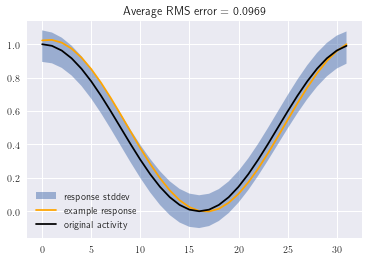

Fourier modes = [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


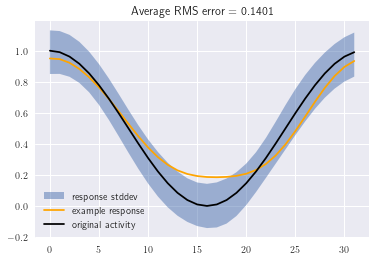

Fourier modes = [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


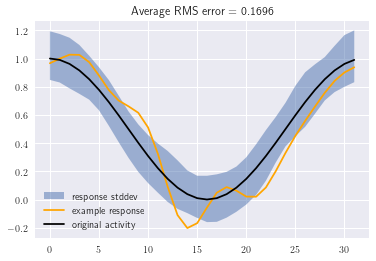

Fourier modes = [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


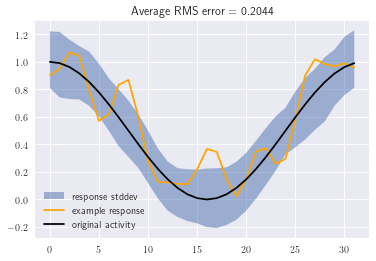

Fourier modes = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


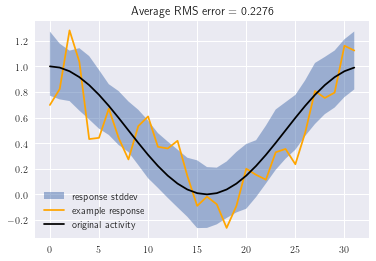

Fourier modes = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]


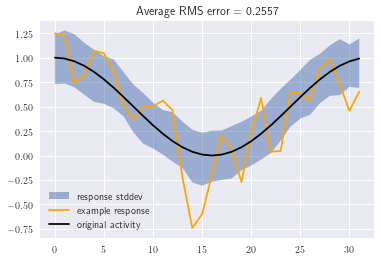

Fourier modes = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]


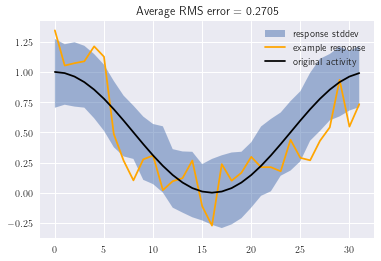

Fourier modes = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


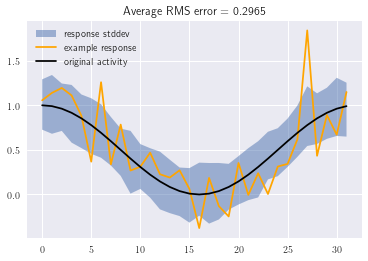

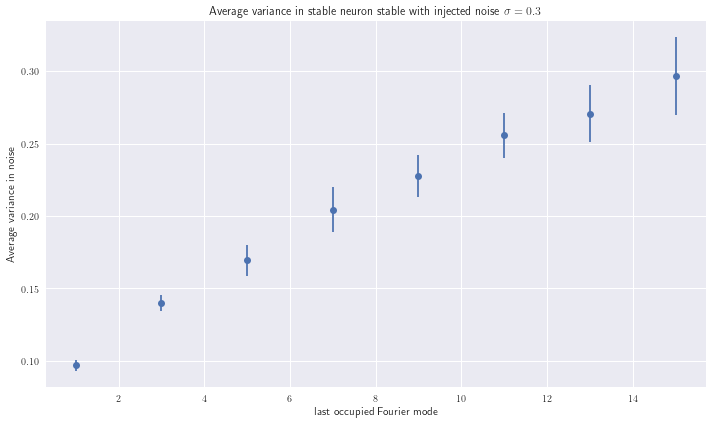

In [4]:
fourier_mode_errors = []
fourier_mode_stddevs = []
noise_stddev = 0.3

last_mode_range = np.arange(2,N//2+2,2)
for last_mode in last_mode_range:
	fw = np.zeros(N//2+1)
	fw[:last_mode] = 1

	W = profile_to_matrix(get_cosine_from_fourier_modes(fw))

	print(f'Fourier modes = {fw}')
	rms_mean, rms_stddev = simulate_and_plot(a, W, noise=noise_stddev)
	fourier_mode_errors.append(rms_mean)
	fourier_mode_stddevs.append(rms_stddev)
plt.figure(figsize=(10,6))
plt.errorbar(last_mode_range-1, fourier_mode_errors, fourier_mode_stddevs, fmt='o')
plt.xlabel('last occupied Fourier mode')
plt.ylabel('Average variance in noise')
plt.title(f'Average variance in stable neuron stable with injected noise $\\sigma={noise_stddev}$')
plt.tight_layout()
plt.show()

The error increases roughly linearly with the number of extra Fourier modes, as predicted

$$||w \ast e|| \propto ||w||$$

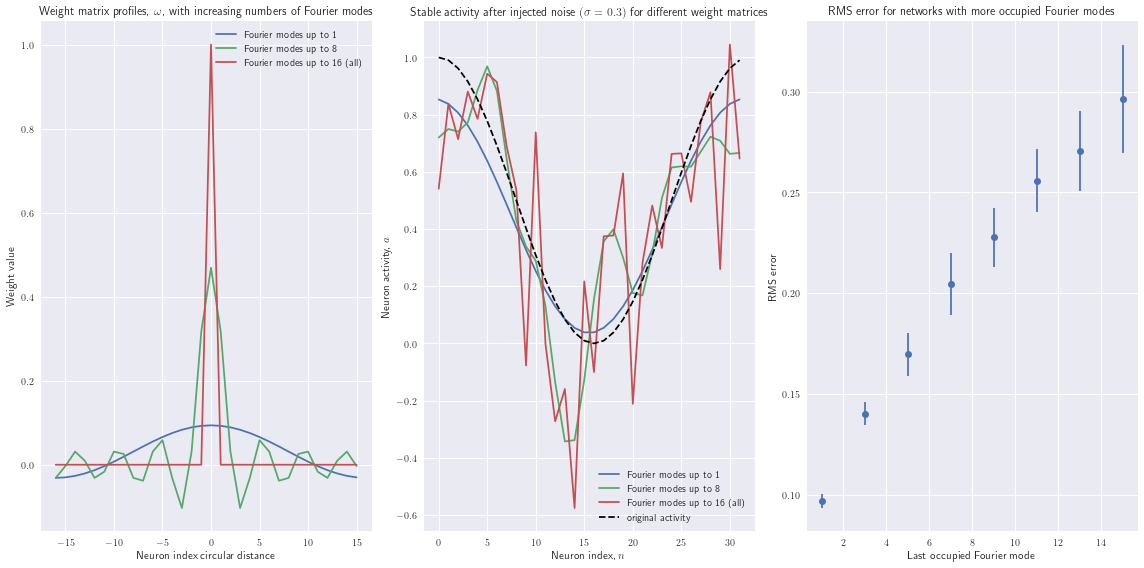

In [5]:
dt=0.001

noisy_activity = a + noise_stddev*np.random.randn(*a.shape)
W_normal = profile_to_matrix(get_cosine_from_fourier_modes([1]*2 + [0]*(N//2+1-2)))
W_half = profile_to_matrix(get_cosine_from_fourier_modes([1]*(N//4) + [0]*(N//2+1-N//4)))
W_full = profile_to_matrix(get_cosine_from_fourier_modes([1]*(N//2+1)))

a_normal = noisy_activity.copy()
a_half = noisy_activity.copy()
a_full = noisy_activity.copy()
for _ in range(50000):
	a_normal += dt*(W_normal@a_normal - a_normal)
	a_half += dt*(W_half@a_half - a_half)
	a_full += dt*(W_full@a_full - a_full)

fig, axs = plt.subplots(1, 3, figsize=(16,8))
axs[0].plot(neuron_indices-N//2, W_normal[N//2,:], label='Fourier modes up to 1')
axs[0].plot(neuron_indices-N//2, W_half[N//2,:], label='Fourier modes up to 8')
axs[0].plot(neuron_indices-N//2, W_full[N//2,:], label='Fourier modes up to 16 (all)')
axs[0].set_xlabel('Neuron index circular distance')
axs[0].set_ylabel('Weight value')
axs[0].set_title('Weight matrix profiles, $\\omega$, with increasing numbers of Fourier modes')
axs[0].legend()

axs[1].plot(neuron_indices, a_normal, label='Fourier modes up to 1')
axs[1].plot(neuron_indices, a_half, label='Fourier modes up to 8')
axs[1].plot(neuron_indices, a_full, label='Fourier modes up to 16 (all)')
axs[1].plot(neuron_indices, a, 'k--', label='original activity')
axs[1].set_xlabel('Neuron index, $n$')
axs[1].set_ylabel('Neuron activity, $a$')
axs[1].set_title(f'Stable activity after injected noise $(\\sigma={noise_stddev})$ for different weight matrices')
axs[1].legend()

axs[2].errorbar(last_mode_range-1, fourier_mode_errors, fourier_mode_stddevs, fmt='o')
axs[2].set_xlabel('Last occupied Fourier mode')
axs[2].set_ylabel('RMS error')
axs[2].set_title(f'RMS error for networks with more occupied Fourier modes')

plt.tight_layout()
plt.savefig('plots/sinusoidal-noise-rejection-fourier-modes.pdf')
plt.show()

## Test how increasing the number of neurons decreases the error

N = 4


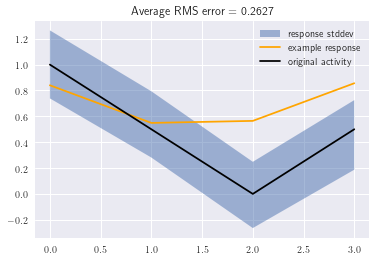

N = 8


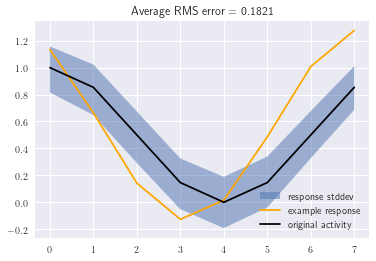

N = 16


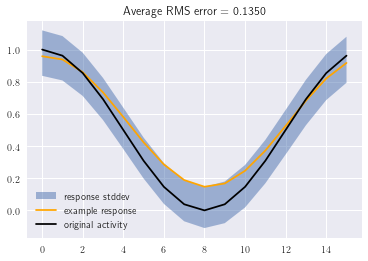

N = 32


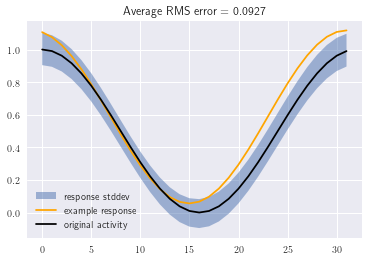

N = 64


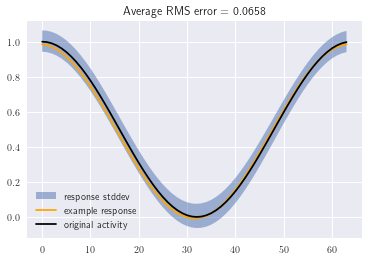

N = 128


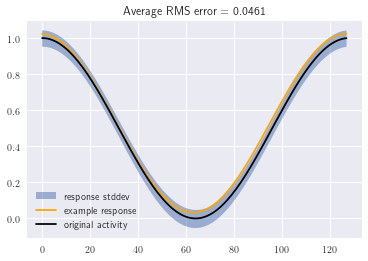

N = 256


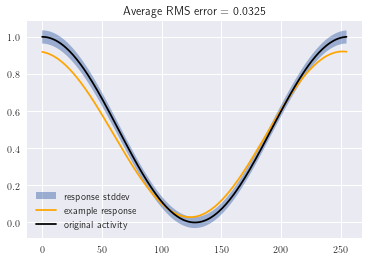

In [6]:
# test for the size of the network
num_neurons_errors = []
num_neurons_stddevs = []

N_range = (2**np.arange(2,9)).astype(np.uint32)
for N in N_range:
	fw = np.zeros(N//2+1)
	fw[:2] = 1
	neuron_indices = np.arange(N)
	a = scaled_cosine(neuron_indices, N)

	W = profile_to_matrix(get_cosine_from_fourier_modes(fw))

	print(f'N = {N}')
	rms_mean, rms_stddev = simulate_and_plot(a, W, noise=noise_stddev)
	num_neurons_errors.append(rms_mean)
	num_neurons_stddevs.append(rms_stddev)
plt.figure(figsize=(10,6))
plt.errorbar(N_range, num_neurons_errors, num_neurons_stddevs, fmt='o')
plt.xlabel('Number of neurons')
plt.ylabel('Average variance in noise')
plt.title(f'Average RMS error in stable neuron state with injected noise $(\\sigma={noise_stddev})$')
plt.xscale('log', base=2)
# plt.xscale(matplotlib.scale.FuncScale(plt.gca(), (lambda x: np.sqrt(x), lambda x: x**2)))
plt.tight_layout()
plt.savefig('plots/sinusoidal-noise-rejection-number-neurons.pdf')
plt.show()

The error decreases slower than logarithmically with the number of neurons